In [1]:
import os
import ast
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Veri dosyaları
file_paths = {
    "All_Beauty": "/content/drive/MyDrive/Colab_Notebooks/aws/meta_All_Beauty.jsonl",
    "Digital_Music": "/content/drive/MyDrive/Colab_Notebooks/aws/meta_Digital_Music.jsonl",
    "Health_and_Personal_Care": "/content/drive/MyDrive/Colab_Notebooks/aws/meta_Health_and_Personal_Care.jsonl",
}

In [3]:
df = None

for category_name, file_path in file_paths.items():
    if not os.path.exists(file_path):
        print(f"Dosya bulunamadı: {file_path}")
        continue

    # JSONL formatında okuma
    tempdf = pd.read_json(file_path, lines=True)

    # İlk DataFrame yoksa direkt ata, varsa birleştir
    if df is None:
        df = tempdf
    else:
        df = pd.concat([df, tempdf], ignore_index=True)


df.info()
titles = df["title"]
details = df["details"]

titles.to_csv("/content/drive/MyDrive/Colab_Notebooks/aws/titles.csv", index=False)
details.to_csv("/content/drive/MyDrive/Colab_Notebooks/aws/details.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243420 entries, 0 to 243419
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    243420 non-null  object 
 1   title            243420 non-null  object 
 2   average_rating   243420 non-null  float64
 3   rating_number    243420 non-null  int64  
 4   features         243420 non-null  object 
 5   description      243420 non-null  object 
 6   price            68365 non-null   float64
 7   images           243420 non-null  object 
 8   videos           243420 non-null  object 
 9   store            225505 non-null  object 
 10  categories       243420 non-null  object 
 11  details          243420 non-null  object 
 12  parent_asin      243420 non-null  object 
 13  bought_together  0 non-null       float64
dtypes: float64(3), int64(1), object(10)
memory usage: 26.0+ MB


In [4]:
df_titles = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/aws/titles.csv", header=None, names=["title"])
df_details = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/aws/details.csv", header=None, names=["details"])

df = pd.concat([df_titles, df_details], axis=1)
len(df)





243421

In [5]:
# #sampling
df = df.sample(n=14000, random_state=42)
df = df.reset_index(drop=True)
print("Örneklem (sampling) sonrası satır sayısı:", len(df))

Örneklem (sampling) sonrası satır sayısı: 14000


In [6]:
#details Kolonunu Sözlüğe Parse Etme
def parse_details(row):
    try:
        parsed = ast.literal_eval(row)
        if isinstance(parsed, dict):
            return parsed
        else:
            return {}
    except:
        return {}

df["details_dict"] = df["details"].fillna("").apply(parse_details)
df["details_dict"].head()

,details_dict
0,"{'Material': 'Acrylic', 'Brand': 'COSICS', 'St..."
1,"{'Color': 'Black', 'Brand': 'Calphdiar', 'Mate..."
2,"{'Brand': 'BSTHP', 'Material': 'Plastic', 'Cap..."
3,{'Package Dimensions': '14.5 x 14 x 4.9 inches...
4,"{'Brand': 'WNAGPOPO', 'Shape': 'Oblong', 'Unit..."


In [7]:
def details_to_text(details_dict):
  #Seçilmiş Bilgileri Metinleştirme brand, color, material
    brand = details_dict.get("Brand", "")
    color = details_dict.get("Color", "")
    material = details_dict.get("Material", "")

    text_parts = []
    if brand:
        text_parts.append(f"brand {brand}")
    if color:
        text_parts.append(f"color {color}")
    if material:
        text_parts.append(f"material {material}")

    return " ".join(text_parts).strip()

df["parsed_details"] = df["details_dict"].apply(details_to_text)
df["parsed_details"].head()

,parsed_details
0,brand COSICS material Acrylic
1,"brand Calphdiar color Black material Cotton,Sy..."
2,brand BSTHP material Plastic
3,
4,brand WNAGPOPO


In [8]:
def clean_text(text):
    """
    Küçük bir regex temizliği:
    - Noktalama işaretlerini kaldırma
    - Küçük harfe dönüştürme
    - Çoklu boşlukları tek boşluğa indirme
    """
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()


df["combined_text"] = df["title"].fillna("") + " " + df["parsed_details"].fillna("")
df["cleaned_text"] = df["combined_text"].apply(clean_text)
df["cleaned_text"].head()

,cleaned_text
0,new short almond shaped nails 200pcs cosics st...
1,calphdiar 20 pairs false eyelashes 16mm19mm mi...
2,travel bottles 30ml empty transparent atomiser...
3,6in1 nail lamp nail dust collector vacuum clea...
4,dog and cat deshedding tool helps stop and red...


In [9]:
vectorizer = TfidfVectorizer(
    stop_words="english",   # İngilizce stop words
    max_features=10000,     # Daha geniş kelime dağarcığı
    min_df=2,               # Nadiren kullanılan kelimeleri atmak için
    max_df=0.8,             # Çok yaygın kelimeleri atmak için
    ngram_range=(1, 2)      # Unigram + Bigram
)

tfidf_matrix = vectorizer.fit_transform(df["cleaned_text"])
tfidf_matrix.shape

(14000, 10000)

In [10]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_matrix.shape

(14000, 14000)

In [11]:
def get_recommendations(product_index, top_n=5):

    sim_scores = list(enumerate(similarity_matrix[product_index]))
    # Skorları büyükten küçüğe sıralıyoruz
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # İlk  top_n+1 alıyoruz
    top_indices = [idx for (idx, score) in sim_scores[1 : top_n + 1]]
    top_scores  = [score for (idx, score) in sim_scores[1 : top_n + 1]]

    results = df.iloc[top_indices].copy()
    results["similarity_score"] = top_scores
    return results[["title", "details", "similarity_score"]]

In [12]:
product_idx = 5
top_n = 5
recommended = get_recommendations(product_idx, top_n)

In [13]:
df.iloc[product_idx][["title", "details"]]

,5
title,"Makeup Remover Pads, 14 Pack Reusable Bamboo S..."
details,"{'Brand': 'Unknown', 'Material': 'Bamboo', 'Sh..."


In [14]:
recommended.head(6)

,title,details,similarity_score
5737,"Makeup Remover Pads Reusable, Voerou 12 Pack B...","{'Brand': 'Voerou', 'Material Feature': 'Reusa...",0.495056
10157,"20 PCS Reusable Makeup Remover Pads, Soft Wash...","{'Brand': 'Senders', 'Material': 'Cotton', 'Sh...",0.483342
12698,Asenappy Reusable Makeup Remover Pads| 16 Pack...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...",0.417880
3165,HOPOSO Reusable Cotton Pads Face Zero Waste 12...,"{'Brand': 'HOPOSO', 'Material': 'Cotton', 'Sha...",0.327312
9865,Andrea Eye Q's Moisturizing Eye Make-up Remove...,{'Product Dimensions': '4 x 2 x 1 inches; 2.89...,0.308743


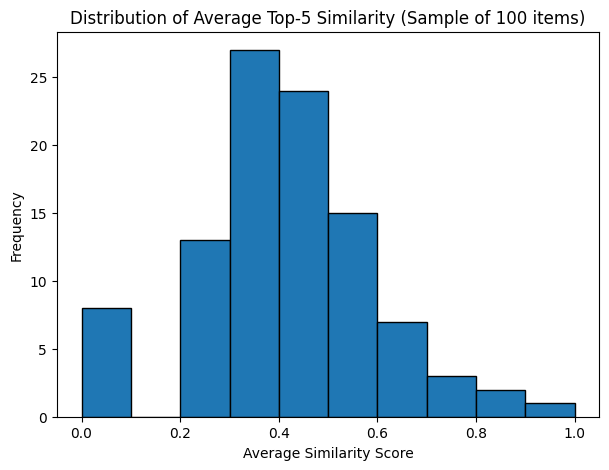

In [15]:
# A) Rastgele 100 ürünün ortalama Top-5 benzerlik skorlarını inceleme
random_indices = random.sample(range(len(df)), 100)
avg_similarities = []
for idx in random_indices:
    recs = get_recommendations(idx, top_n=5)
    avg_sim = recs["similarity_score"].mean()
    avg_similarities.append(avg_sim)

plt.figure(figsize=(7, 5))
plt.hist(avg_similarities, bins=10, edgecolor='black')
plt.title("Distribution of Average Top-5 Similarity (Sample of 100 items)")
plt.xlabel("Average Similarity Score")
plt.ylabel("Frequency")
plt.show()

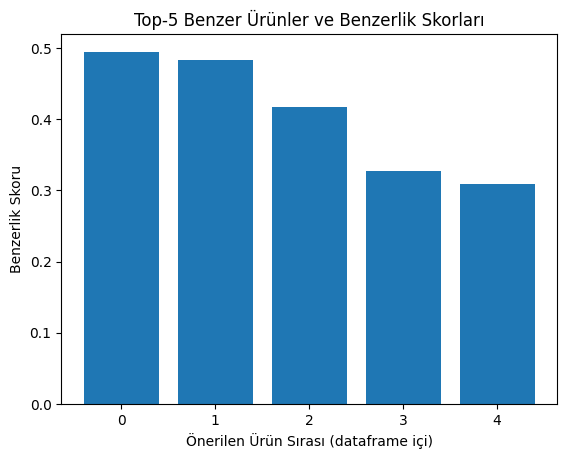


Seçilen Ürün: Makeup Remover Pads, 14 Pack Reusable Bamboo Soft Face Clean Pads Facial Skin Care Wash Cleansing Pads with Laundry Bag and Cosmetic Bag, Assorted Colors
Önerilen Ürünler ve Skorlar:
                                                    title  \
5737   Makeup Remover Pads Reusable, Voerou 12 Pack B...   
10157  20 PCS Reusable Makeup Remover Pads, Soft Wash...   
12698  Asenappy Reusable Makeup Remover Pads| 16 Pack...   
3165   HOPOSO Reusable Cotton Pads Face Zero Waste 12...   
9865   Andrea Eye Q's Moisturizing Eye Make-up Remove...   

                                                 details  similarity_score  
5737   {'Brand': 'Voerou', 'Material Feature': 'Reusa...          0.495056  
10157  {'Brand': 'Senders', 'Material': 'Cotton', 'Sh...          0.483342  
12698  {'Is Discontinued By Manufacturer': 'No', 'Pro...          0.417880  
3165   {'Brand': 'HOPOSO', 'Material': 'Cotton', 'Sha...          0.327312  
9865   {'Product Dimensions': '4 x 2 x 1 inches; 2.89..

In [16]:
# B) Seçilen ürünün Top-5 benzerlik skorlarını bar grafikte göster
recs = get_recommendations(product_idx, top_n=5)
plt.figure()
plt.bar(range(len(recs)), recs["similarity_score"])
plt.title("Top-5 Benzer Ürünler ve Benzerlik Skorları")
plt.xlabel("Önerilen Ürün Sırası (dataframe içi)")
plt.ylabel("Benzerlik Skoru")
plt.show()

print("\nSeçilen Ürün:", df.iloc[product_idx]["title"])
print("Önerilen Ürünler ve Skorlar:\n", recs)

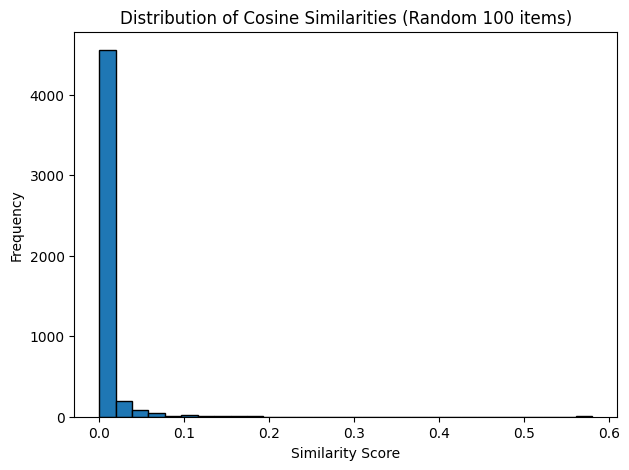

In [17]:
# C) Rastgele 100 ürünlük alt matrisle benzerlik dağılımı ve heatmap
sample_indices = np.random.choice(df.shape[0], size=100, replace=False)
sample_indices = sorted(sample_indices)
similarity_submatrix = similarity_matrix[sample_indices, :][:, sample_indices]

# Üst üçgeni alarak histogram
triu_indices = np.triu_indices_from(similarity_submatrix, k=1)
similarities = similarity_submatrix[triu_indices]

plt.figure(figsize=(7, 5))
plt.hist(similarities, bins=30, edgecolor='black')
plt.title("Distribution of Cosine Similarities (Random 100 items)")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()



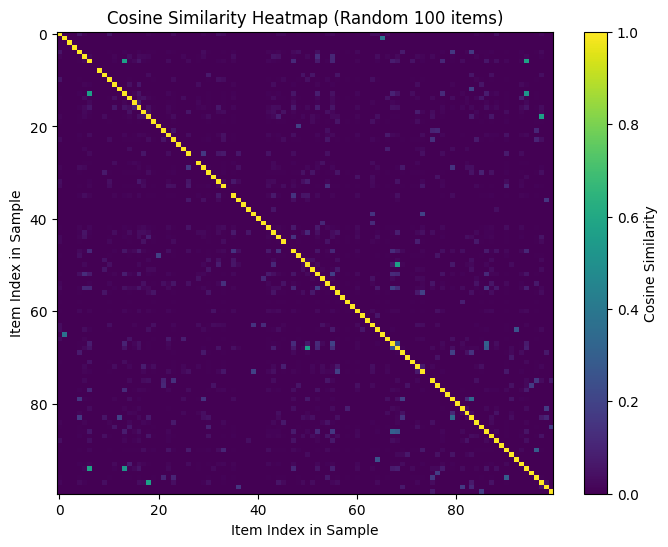

In [18]:
plt.figure(figsize=(8, 6))
plt.imshow(similarity_submatrix, cmap='viridis', aspect='auto')
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity Heatmap (Random 100 items)")
plt.xlabel("Item Index in Sample")
plt.ylabel("Item Index in Sample")
plt.show()

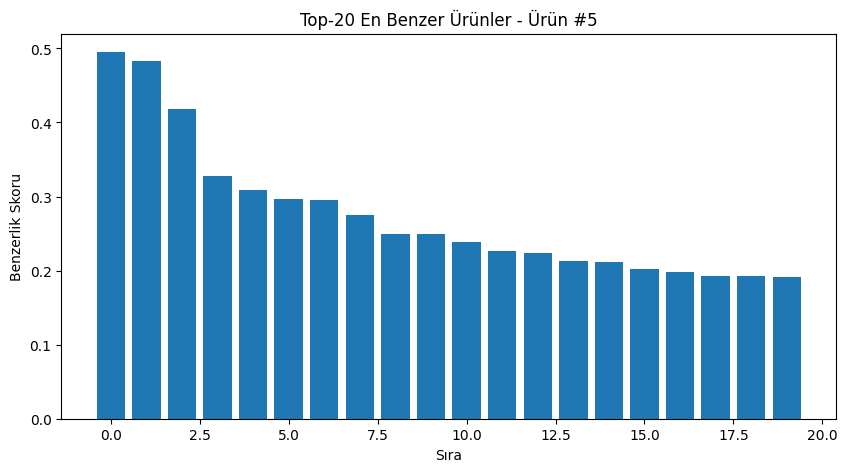


Ürün #5 için Top-20 en benzer ürünler:
1. Skor: 0.495, Başlık: Makeup Remover Pads Reusable, Voerou 12 Pack Bamboo Facial Toner pads Cleansing Towel Wipes Cloth Washable Cotton Round pads with Laundry Bag, Chemical Free, 4 Color
2. Skor: 0.483, Başlık: 20 PCS Reusable Makeup Remover Pads, Soft Washable Bamboo Cotton Face Cleansing Pads with Laundry Bag Eco-friendly for All Skin Types
3. Skor: 0.418, Başlık: Asenappy Reusable Makeup Remover Pads| 16 Pack with Laundry Bag | Bamboo Cotton | Eco-friendly | Waste Free | Luxury (bamboo cotton)
4. Skor: 0.327, Başlık: HOPOSO Reusable Cotton Pads Face Zero Waste 12 Pack Cotton Rounds Eye Makeup Remover Cloth Washable Cleansing Wipes Eco-friendly Bamboo Organic Cotton Rounds with Laundry Bag and Makeup Sponge
5. Skor: 0.309, Başlık: Andrea Eye Q's Moisturizing Eye Make-up Remover Pads
6. Skor: 0.296, Başlık: Cosmetic Bag, HOZMLIFE Lovely Transparent Waterproof Make Up Bag, Portable Large Capacity Cosmetic Bag Storage Bag Travel Wash Bag for wo

In [19]:
# D) Tek Bir Ürün İçin Top-20 Benzerlik Skorunu Bar Grafikte Göster
product_idx = 5
top_n = 20
recs_20 = get_recommendations(product_idx, top_n=top_n)

scores = recs_20["similarity_score"].values
titles = recs_20["title"].values

plt.figure(figsize=(10, 5))
plt.bar(range(top_n), scores)
plt.title(f"Top-{top_n} En Benzer Ürünler - Ürün #{product_idx}")
plt.xlabel("Sıra")
plt.ylabel("Benzerlik Skoru")
plt.show()

print(f"\nÜrün #{product_idx} için Top-{top_n} en benzer ürünler:")
for i, (title, sc) in enumerate(zip(titles, scores)):
    print(f"{i+1}. Skor: {sc:.3f}, Başlık: {title}")